# Assignment 01: Multi-class Classification 
In this Assignment, you will train a deep model on the CIFAR10 from the scratch using PyTorch.

### Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### Hyperparameters

In [2]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 64
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATES = [1e-1,1e-2,5e-3,1e-3,1e-4]
MOMENTUM = 0.9
STEP=5
GAMMA=0.5


### Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
torch.cuda.empty_cache()

In [5]:
device_properties = torch.cuda.get_device_properties(device)
total_memory = device_properties.total_memory
free_memory = torch.cuda.max_memory_allocated(device)

print(f"Total CUDA Device Memory: {total_memory / (1024**2):.2f} MB")
print(f"Free CUDA Device Memory: {free_memory / (1024**2):.2f} MB")

Total CUDA Device Memory: 5952.00 MB
Free CUDA Device Memory: 0.00 MB


In [5]:
print(device)

cuda:0



### Dataset


In [4]:
'''
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
'''

Files already downloaded and verified
Files already downloaded and verified


In [6]:
transform_cifar10_train = transforms.Compose([
    transforms.Resize(224),  # 调整图像大小为224x224
    transforms.RandomCrop(224, padding=4),  # 随机裁剪
    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# 加载训练集
train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                         download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                               shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


### Model

In [88]:
'''
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
'''

In [7]:
from torchvision.models import alexnet

In [8]:
model = alexnet(pretrained=True)
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [89]:
'''
model = ConvNet()
model.to(device)
'''

ConvNet(
  (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=288, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

### Optimizer

In [9]:
optimizers = []
schedulers = []
for learning_rate in LEARNING_RATES:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=MOMENTUM)
    optimizers.append(optimizer)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)
    schedulers.append(scheduler)

### Task 1: per batch training/testing
---

Please denfine two function named ``train_batch`` and ``test_batch``. These functions are essential for training and evaluating machine learning models using batched data from dataloaders.

**To do**: 
1. Define the loss function i.e [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
2. Take the image as the input and generate the output using the pre-defined SimpleNet.
3. Calculate the loss between the output and the corresponding label using the loss function.

In [10]:
##################### Write your answer here ##################
# Define the loss function
criterion = nn.CrossEntropyLoss()
###############################################################

In [11]:
def train_batch(model, image, target):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """
    
    ##################### Write your answer here ##################

    output = model(image)
    loss = criterion(output, target)
    ###############################################################

    return output, loss

In [12]:

def test_batch(model, image, target):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################

    output = model(image)
    loss = criterion(output, target)
    ###############################################################

    return output, loss

### Model Training

In [13]:
def train(optimizer,scheduler,NUM_EPOCHS,model,train_dataloader,train_set,EVAL_INTERVAL,test_dataloader,test_set,SAVE_DIR):
    training_loss = []
    training_acc = []
    testing_loss = []
    testing_acc = []
    time_epochs = []
    testing_prec = []
    testing_f1 = []

    for epoch in range(NUM_EPOCHS):
        model.train()
        torch.cuda.empty_cache()

        ##########################
        ### Training
        ##########################
        start = time.perf_counter()
        
        running_cls_loss = 0.0
        running_cls_corrects = 0

        for batch_idx, (image, target) in enumerate(train_dataloader):

            image = image.to(device)
            target = target.to(device)

            # train model
            outputs, loss = train_batch(model, image, target)
            _, preds = torch.max(outputs, 1)

            loss_data = loss.data.item()
            
            if np.isnan(loss_data):
                raise ValueError('loss is nan while training')
            
            running_cls_loss += loss.item()
            running_cls_corrects += torch.sum(preds == target.data)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        epoch_loss = running_cls_loss / len(train_set)
        epoch_acc = running_cls_corrects.double() / len(train_set)

        print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        training_loss.append(epoch_loss)
        training_acc.append(epoch_acc.item())
        # .cpu().detach().numpy()
        # change learning rate
        scheduler.step()
        current_lr = scheduler.get_last_lr()
        print(current_lr)
        
        end = time.perf_counter()
        runTime = end - start
        time_epochs.append(runTime)

        ##########################
        ### Testing
        ##########################
        # # eval model during training or in the last epoch
        if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
            print('Begin test......')
            test_preds = []
            test_labels = []
            test_probs = []
            model.eval()
            #torch.cuda.empty_cache()

            val_loss = 0.0
            with torch.no_grad():
                for batch_idx, (image, target) in enumerate(test_dataloader):

                    image = image.to(device)
                    target = target.to(device)

                    # test model
                    outputs, loss = test_batch(model, image, target)
                    _, preds = torch.max(outputs, 1)

                    probs = torch.nn.functional.softmax(outputs, dim=1)
                    test_probs.append(probs)

                    test_preds.extend(preds.cpu().numpy())
                    test_labels.extend(target.cpu().numpy())

                    val_loss += loss.item()

            val_loss = val_loss / len(test_set)
            print(f'Test Loss: {val_loss:.4f}')
            testing_loss.append(val_loss)
            # .cpu().detach().numpy()
            # save the model in last epoch
            
            test_accuracy = accuracy_score(test_labels, test_preds)
            test_precision = precision_score(test_labels, test_preds, average='macro')
            test_f1 = f1_score(test_labels, test_preds, average='macro')
            testing_acc.append(test_accuracy)
            testing_prec.append(test_precision)
            testing_f1.append(test_f1)
            
            
            print(f'Acc: {test_accuracy:.4f} Precision: {test_precision:.4f} F1:{test_f1:.4f}')

            if (epoch +1) == NUM_EPOCHS:

                state = {
                'state_dict': model.state_dict(),
                'acc': epoch_acc,
                'epoch': (epoch+1),
                }

                # check the dir
                if not os.path.exists(SAVE_DIR):
                    os.makedirs(SAVE_DIR)

                # save the state
                torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))
    
    return training_loss,training_acc,time_epochs,testing_loss,testing_acc,testing_prec,testing_f1

for experiment2

In [14]:
def train_forbatchexp(optimizer,scheduler,NUM_EPOCHS,model,train_dataloader,train_set,EVAL_INTERVAL,test_dataloader,test_set,SAVE_DIR):
    testing_loss = []
    testing_acc = []

    for epoch in range(NUM_EPOCHS):
        model.train()
        torch.cuda.empty_cache()

        ##########################
        ### Training
        ##########################
        
        running_cls_loss = 0.0
        running_cls_corrects = 0

        for batch_idx, (image, target) in enumerate(train_dataloader):

            image = image.to(device)
            target = target.to(device)

            # train model
            outputs, loss = train_batch(model, image, target)
            _, preds = torch.max(outputs, 1)

            loss_data = loss.data.item()
            
            if np.isnan(loss_data):
                raise ValueError('loss is nan while training')
            
            running_cls_loss += loss.item()
            running_cls_corrects += torch.sum(preds == target.data)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        epoch_loss = running_cls_loss / len(train_set)
        epoch_acc = running_cls_corrects.double() / len(train_set)

        print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        scheduler.step()
        

        ##########################
        ### Testing
        ##########################
        # # eval model during training or in the last epoch
        if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
            print('Begin test......')
            model.eval()
            
            val_loss = 0.0
            test_labels = []
            test_preds = []
            with torch.no_grad():
                for batch_idx, (image, target) in enumerate(test_dataloader):

                    image = image.to(device)
                    target = target.to(device)

                    # test model
                    outputs, loss = test_batch(model, image, target)
                    _, preds = torch.max(outputs, 1)

                    test_labels.extend(target.cpu().numpy())
                    test_preds.extend(preds.cpu().numpy())

                    val_loss += loss.item()
            
            val_loss = val_loss / len(test_set)
            testing_loss.append(val_loss)
            # .cpu().detach().numpy()
            # save the model in last epoch
            
            test_accuracy = accuracy_score(test_labels, test_preds)
            testing_acc.append(test_accuracy)
            
            
            print(f'Test Loss: {val_loss:.4f} Acc: {test_accuracy:.4f}')

            if (epoch +1) == NUM_EPOCHS:

                state = {
                'state_dict': model.state_dict(),
                'acc': epoch_acc,
                'epoch': (epoch+1),
                }

                # check the dir
                if not os.path.exists(SAVE_DIR):
                    os.makedirs(SAVE_DIR)

                # save the state
                torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))
    
    return testing_loss,testing_acc 

In [14]:
NUM_EPOCHS = 20

### Experiments

#### 1. batch size = 200, lr = 5e-3, 1e-3, 1e-4, #epoch = 20

5e-3,200,20

In [14]:
train_loss_1,train_acc_1,time_epochs_1,test_loss_1,test_acc_1,test_prec_1,test_f1_1 = train(optimizers[2],schedulers[2],NUM_EPOCHS,model,train_dataloader,train_set,EVAL_INTERVAL,test_dataloader,test_set,SAVE_DIR)

Epoch: 1/20 Train Loss: 0.0112 Acc: 0.3526
Begin test......
Test Loss: 0.0061
Acc: 0.5572 Precision: 0.5893 F1:0.5493
Epoch: 2/20 Train Loss: 0.0051 Acc: 0.6413
Begin test......
Test Loss: 0.0037
Acc: 0.7424 Precision: 0.7458 F1:0.7382
Epoch: 3/20 Train Loss: 0.0034 Acc: 0.7683
Begin test......
Test Loss: 0.0026
Acc: 0.8185 Precision: 0.8226 F1:0.8182
Epoch: 4/20 Train Loss: 0.0025 Acc: 0.8217
Begin test......
Test Loss: 0.0022
Acc: 0.8527 Precision: 0.8531 F1:0.8517
Epoch: 5/20 Train Loss: 0.0022 Acc: 0.8501
Begin test......
Test Loss: 0.0022
Acc: 0.8486 Precision: 0.8522 F1:0.8464
Epoch: 6/20 Train Loss: 0.0017 Acc: 0.8842
Begin test......
Test Loss: 0.0017
Acc: 0.8869 Precision: 0.8875 F1:0.8863
Epoch: 7/20 Train Loss: 0.0015 Acc: 0.8966
Begin test......
Test Loss: 0.0016
Acc: 0.8898 Precision: 0.8890 F1:0.8884
Epoch: 8/20 Train Loss: 0.0014 Acc: 0.9018
Begin test......
Test Loss: 0.0015
Acc: 0.8951 Precision: 0.8954 F1:0.8944
Epoch: 9/20 Train Loss: 0.0013 Acc: 0.9078
Begin test...

1e-3,200,20

In [26]:
train_loss_2,train_acc_2,time_epochs_2,test_loss_2,test_acc_2,test_prec_2,test_f1_2 = train(optimizers[3],schedulers[3],NUM_EPOCHS,model,train_dataloader,train_set,EVAL_INTERVAL,test_dataloader,test_set,SAVE_DIR)

Epoch: 1/20 Train Loss: 0.0084 Acc: 0.4503
Begin test......
Test Loss: 0.0048
Acc: 0.6611 Precision: 0.6718 F1:0.6563
Epoch: 4/20 Train Loss: 0.0025 Acc: 0.8250
Begin test......
Test Loss: 0.0022
Acc: 0.8502 Precision: 0.8518 F1:0.8488
Epoch: 5/20 Train Loss: 0.0022 Acc: 0.8478
Begin test......
Test Loss: 0.0019
Acc: 0.8688 Precision: 0.8707 F1:0.8682
Epoch: 6/20 Train Loss: 0.0019 Acc: 0.8650
Begin test......
Epoch: 7/20 Train Loss: 0.0018 Acc: 0.8723
Begin test......
Test Loss: 0.0017
Acc: 0.8847 Precision: 0.8847 F1:0.8840
Epoch: 8/20 Train Loss: 0.0018 Acc: 0.8780
Begin test......
Test Loss: 0.0017
Acc: 0.8862 Precision: 0.8860 F1:0.8857
Epoch: 9/20 Train Loss: 0.0017 Acc: 0.8810
Begin test......
Test Loss: 0.0017
Acc: 0.8871 Precision: 0.8872 F1:0.8859
Epoch: 10/20 Train Loss: 0.0016 Acc: 0.8867
Begin test......
Test Loss: 0.0016
Acc: 0.8941 Precision: 0.8938 F1:0.8936
Epoch: 11/20 Train Loss: 0.0015 Acc: 0.8930
Begin test......
Test Loss: 0.0016
Acc: 0.8935 Precision: 0.8934 F1:0

1e-4,200,20

In [37]:
train_loss_3,train_acc_3,time_epochs_3,test_loss_3,test_acc_3,test_prec_3,test_f1_3 = train(optimizers[4],schedulers[4],NUM_EPOCHS,model,train_dataloader,train_set,EVAL_INTERVAL,test_dataloader,test_set,SAVE_DIR)

Epoch: 1/20 Train Loss: 0.0133 Acc: 0.2765
Begin test......
Test Loss: 0.0074
Acc: 0.4801 Precision: 0.4079 F1:0.3942
Epoch: 2/20 Train Loss: 0.0070 Acc: 0.4918
Begin test......
Test Loss: 0.0058
Acc: 0.5879 Precision: 0.4960 F1:0.4878
Epoch: 3/20 Train Loss: 0.0059 Acc: 0.5790
Begin test......
Test Loss: 0.0049
Acc: 0.6610 Precision: 0.5087 F1:0.5074
Epoch: 4/20 Train Loss: 0.0051 Acc: 0.6411
Begin test......
Test Loss: 0.0042
Acc: 0.7133 Precision: 0.5514 F1:0.5482
Epoch: 5/20 Train Loss: 0.0044 Acc: 0.6899
Begin test......
Test Loss: 0.0037
Acc: 0.7501 Precision: 0.5786 F1:0.5769
Epoch: 6/20 Train Loss: 0.0041 Acc: 0.7145
Begin test......
Test Loss: 0.0035
Acc: 0.7634 Precision: 0.6364 F1:0.6348
Epoch: 7/20 Train Loss: 0.0039 Acc: 0.7278
Begin test......
Test Loss: 0.0033
Acc: 0.7770 Precision: 0.7073 F1:0.7055
Epoch: 8/20 Train Loss: 0.0037 Acc: 0.7386
Begin test......
Test Loss: 0.0032
Acc: 0.7872 Precision: 0.7148 F1:0.7148
Epoch: 9/20 Train Loss: 0.0036 Acc: 0.7511
Begin test...

training loss & epoch

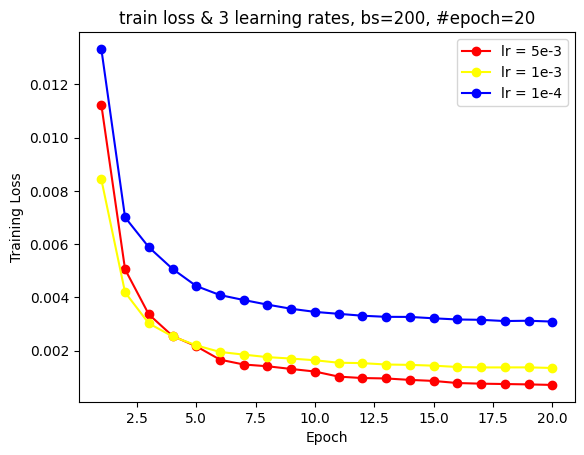

In [38]:
epochs = list(range(1, 21))
plt.plot(epochs, train_loss_1, label='lr = 5e-3', color='red', marker='o')
plt.plot(epochs, train_loss_2, label='lr = 1e-3', color='yellow', marker='o')
plt.plot(epochs, train_loss_3, label='lr = 1e-4', color='blue', marker='o')

plt.title('train loss & 3 learning rates, bs=200, #epoch=20')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

# 添加图例
plt.legend()

# 显示图表
plt.savefig('results/train loss 3 compare.jpg')
plt.show()

testing loss & epoch

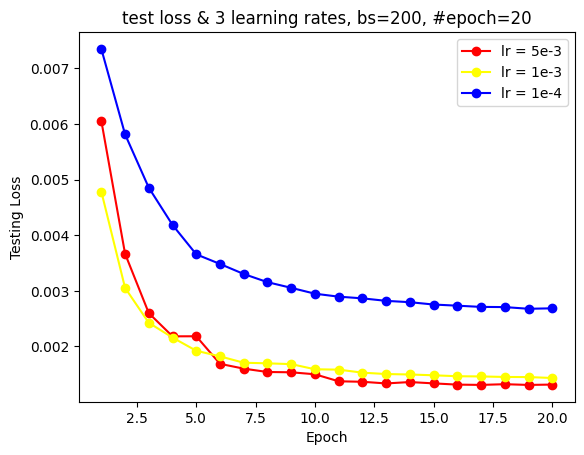

In [39]:
epochs = list(range(1, 21))
plt.plot(epochs, test_loss_1, label='lr = 5e-3', color='red', marker='o')
plt.plot(epochs, test_loss_2, label='lr = 1e-3', color='yellow', marker='o')
plt.plot(epochs, test_loss_3, label='lr = 1e-4', color='blue', marker='o')

plt.title('test loss & 3 learning rates, bs=200, #epoch=20')
plt.xlabel('Epoch')
plt.ylabel('Testing Loss')

# 添加图例
plt.legend()

# 显示图表
plt.savefig('results/test loss 3 compare.jpg')
plt.show()

time & epoch

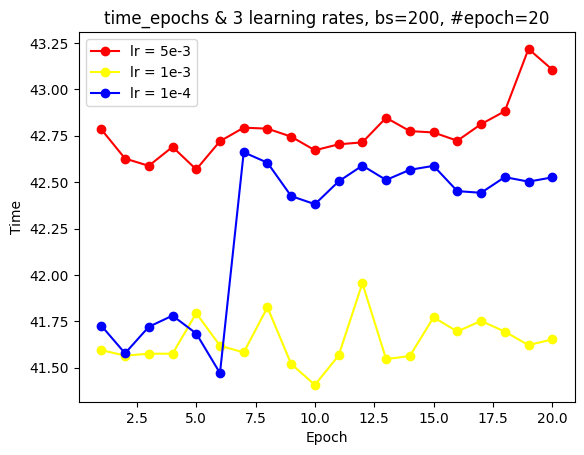

In [52]:
epochs = list(range(1, 21))
plt.plot(epochs, time_epochs_1, label='lr = 5e-3', color='red', marker='o')
plt.plot(epochs, time_epochs_2, label='lr = 1e-3', color='yellow', marker='o')
plt.plot(epochs, time_epochs_3, label='lr = 1e-4', color='blue', marker='o')

plt.title('time_epochs & 3 learning rates, bs=200, #epoch=20')
plt.xlabel('Epoch')
plt.ylabel('Time')

# 添加图例
plt.legend()

# 显示图表
plt.savefig('results/time 3 compare.jpg')
plt.show()

test accuracy/precision & epoch

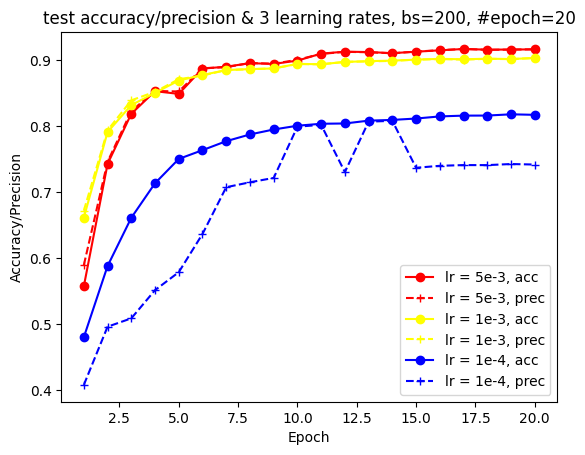

In [51]:
epochs = list(range(1, 21))
plt.plot(epochs, test_acc_1, label='lr = 5e-3, acc', color='red', marker='o')
plt.plot(epochs, test_prec_1, label='lr = 5e-3, prec', color='red', marker='+', linestyle='--')
plt.plot(epochs, test_acc_2, label='lr = 1e-3, acc', color='yellow', marker='o')
plt.plot(epochs, test_prec_2, label='lr = 1e-3, prec', color='yellow', marker='+', linestyle='--')
plt.plot(epochs, test_acc_3, label='lr = 1e-4, acc', color='blue', marker='o')
plt.plot(epochs, test_prec_3, label='lr = 1e-4, prec', color='blue', marker='+', linestyle='--')

plt.title('test accuracy/precision & 3 learning rates, bs=200, #epoch=20')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Precision')

# 添加图例
plt.legend()

# 显示图表
plt.savefig('results/test acc_prec 3 compare.jpg')
plt.show()

#### 2. batch size = 32，64，128, lr = 1e-3, 1e-4, #epoch = 20

1e-3,32,20

In [91]:
test_loss_4,test_acc_4 = train_forbatchexp(optimizers[3],schedulers[3],NUM_EPOCHS,model,train_dataloader,train_set,EVAL_INTERVAL,test_dataloader,test_set,SAVE_DIR)

Epoch: 1/20 Train Loss: 0.0311 Acc: 0.6579
Begin test......
Test Loss: 0.0150 Acc: 0.8378
Epoch: 2/20 Train Loss: 0.0154 Acc: 0.8319
Begin test......
Test Loss: 0.0129 Acc: 0.8606
Epoch: 3/20 Train Loss: 0.0119 Acc: 0.8679
Begin test......
Test Loss: 0.0112 Acc: 0.8785
Epoch: 4/20 Train Loss: 0.0102 Acc: 0.8871
Begin test......
Test Loss: 0.0101 Acc: 0.8903
Epoch: 5/20 Train Loss: 0.0088 Acc: 0.9022
Begin test......
Test Loss: 0.0092 Acc: 0.8990
Epoch: 6/20 Train Loss: 0.0064 Acc: 0.9285
Begin test......
Test Loss: 0.0077 Acc: 0.9178
Epoch: 7/20 Train Loss: 0.0057 Acc: 0.9361
Begin test......
Test Loss: 0.0081 Acc: 0.9152
Epoch: 8/20 Train Loss: 0.0053 Acc: 0.9405
Begin test......
Test Loss: 0.0079 Acc: 0.9189
Epoch: 9/20 Train Loss: 0.0048 Acc: 0.9458
Begin test......
Test Loss: 0.0079 Acc: 0.9161
Epoch: 10/20 Train Loss: 0.0045 Acc: 0.9493
Begin test......
Test Loss: 0.0075 Acc: 0.9236
Epoch: 11/20 Train Loss: 0.0036 Acc: 0.9604
Begin test......
Test Loss: 0.0076 Acc: 0.9244
Epoch: 1

1e-3,64,20

In [105]:
test_loss_5,test_acc_5 = train_forbatchexp(optimizers[3],schedulers[3],NUM_EPOCHS,model,train_dataloader,train_set,EVAL_INTERVAL,test_dataloader,test_set,SAVE_DIR)

Epoch: 1/20 Train Loss: 0.0175 Acc: 0.6223
Begin test......
Test Loss: 0.0086 Acc: 0.8154
Epoch: 2/20 Train Loss: 0.0081 Acc: 0.8216
Begin test......
Test Loss: 0.0064 Acc: 0.8638
Epoch: 3/20 Train Loss: 0.0065 Acc: 0.8560
Begin test......
Test Loss: 0.0054 Acc: 0.8803
Epoch: 4/20 Train Loss: 0.0056 Acc: 0.8759
Begin test......
Test Loss: 0.0051 Acc: 0.8858
Epoch: 5/20 Train Loss: 0.0049 Acc: 0.8909
Begin test......
Test Loss: 0.0048 Acc: 0.8964
Epoch: 6/20 Train Loss: 0.0040 Acc: 0.9113
Begin test......
Test Loss: 0.0044 Acc: 0.9087
Epoch: 7/20 Train Loss: 0.0037 Acc: 0.9178
Begin test......
Test Loss: 0.0042 Acc: 0.9077
Epoch: 8/20 Train Loss: 0.0034 Acc: 0.9216
Begin test......
Test Loss: 0.0041 Acc: 0.9115
Epoch: 9/20 Train Loss: 0.0033 Acc: 0.9270
Begin test......
Test Loss: 0.0041 Acc: 0.9108
Epoch: 10/20 Train Loss: 0.0030 Acc: 0.9319
Begin test......
Test Loss: 0.0041 Acc: 0.9121
Epoch: 11/20 Train Loss: 0.0027 Acc: 0.9394
Begin test......
Test Loss: 0.0038 Acc: 0.9187
Epoch: 1

1e-3,128,20

In [118]:
test_loss_6,test_acc_6 = train_forbatchexp(optimizers[3],schedulers[3],NUM_EPOCHS,model,train_dataloader,train_set,EVAL_INTERVAL,test_dataloader,test_set,SAVE_DIR)

Epoch: 1/20 Train Loss: 0.0118 Acc: 0.4944
Begin test......
Test Loss: 0.0069 Acc: 0.6954
Epoch: 2/20 Train Loss: 0.0058 Acc: 0.7407
Begin test......
Test Loss: 0.0044 Acc: 0.8111
Epoch: 3/20 Train Loss: 0.0042 Acc: 0.8126
Begin test......
Test Loss: 0.0034 Acc: 0.8541
Epoch: 4/20 Train Loss: 0.0035 Acc: 0.8443
Begin test......
Test Loss: 0.0032 Acc: 0.8606
Epoch: 5/20 Train Loss: 0.0032 Acc: 0.8605
Begin test......
Test Loss: 0.0028 Acc: 0.8804
Epoch: 6/20 Train Loss: 0.0027 Acc: 0.8811
Begin test......
Test Loss: 0.0025 Acc: 0.8916
Epoch: 7/20 Train Loss: 0.0025 Acc: 0.8899
Begin test......
Test Loss: 0.0025 Acc: 0.8940
Epoch: 8/20 Train Loss: 0.0024 Acc: 0.8957
Begin test......
Test Loss: 0.0025 Acc: 0.8927
Epoch: 9/20 Train Loss: 0.0023 Acc: 0.8983
Begin test......
Test Loss: 0.0024 Acc: 0.8970
Epoch: 10/20 Train Loss: 0.0022 Acc: 0.9025
Begin test......
Test Loss: 0.0023 Acc: 0.8994
Epoch: 11/20 Train Loss: 0.0020 Acc: 0.9108
Begin test......
Test Loss: 0.0023 Acc: 0.8994
Epoch: 1

1e-4,32,20

In [131]:
test_loss_7,test_acc_7 = train_forbatchexp(optimizers[4],schedulers[4],NUM_EPOCHS,model,train_dataloader,train_set,EVAL_INTERVAL,test_dataloader,test_set,SAVE_DIR)

Epoch: 1/20 Train Loss: 0.0439 Acc: 0.5329
Begin test......
Test Loss: 0.0229 Acc: 0.7496
Epoch: 2/20 Train Loss: 0.0222 Acc: 0.7527
Begin test......
Test Loss: 0.0173 Acc: 0.8092
Epoch: 3/20 Train Loss: 0.0177 Acc: 0.8041
Begin test......
Test Loss: 0.0139 Acc: 0.8496
Epoch: 4/20 Train Loss: 0.0154 Acc: 0.8285
Begin test......
Test Loss: 0.0128 Acc: 0.8625
Epoch: 5/20 Train Loss: 0.0141 Acc: 0.8453
Begin test......
Test Loss: 0.0119 Acc: 0.8709
Epoch: 6/20 Train Loss: 0.0127 Acc: 0.8596
Begin test......
Test Loss: 0.0115 Acc: 0.8787
Epoch: 7/20 Train Loss: 0.0122 Acc: 0.8665
Begin test......
Test Loss: 0.0113 Acc: 0.8760
Epoch: 8/20 Train Loss: 0.0116 Acc: 0.8714
Begin test......
Test Loss: 0.0108 Acc: 0.8859
Epoch: 9/20 Train Loss: 0.0115 Acc: 0.8722
Begin test......
Test Loss: 0.0105 Acc: 0.8883
Epoch: 10/20 Train Loss: 0.0111 Acc: 0.8760
Begin test......
Test Loss: 0.0103 Acc: 0.8862
Epoch: 11/20 Train Loss: 0.0106 Acc: 0.8809
Begin test......
Test Loss: 0.0101 Acc: 0.8904
Epoch: 1

1e-4,64,20

In [144]:
test_loss_8,test_acc_8 = train_forbatchexp(optimizers[4],schedulers[4],NUM_EPOCHS,model,train_dataloader,train_set,EVAL_INTERVAL,test_dataloader,test_set,SAVE_DIR)

Epoch: 1/20 Train Loss: 0.0274 Acc: 0.4467
Begin test......
Test Loss: 0.0156 Acc: 0.6535
Epoch: 2/20 Train Loss: 0.0143 Acc: 0.6782
Begin test......
Test Loss: 0.0106 Acc: 0.7701
Epoch: 3/20 Train Loss: 0.0109 Acc: 0.7570
Begin test......
Test Loss: 0.0090 Acc: 0.8034
Epoch: 4/20 Train Loss: 0.0095 Acc: 0.7897
Begin test......
Test Loss: 0.0077 Acc: 0.8338
Epoch: 5/20 Train Loss: 0.0086 Acc: 0.8108
Begin test......
Test Loss: 0.0074 Acc: 0.8414
Epoch: 6/20 Train Loss: 0.0079 Acc: 0.8231
Begin test......
Test Loss: 0.0069 Acc: 0.8560
Epoch: 7/20 Train Loss: 0.0076 Acc: 0.8304
Begin test......
Test Loss: 0.0066 Acc: 0.8574
Epoch: 8/20 Train Loss: 0.0074 Acc: 0.8347
Begin test......
Test Loss: 0.0065 Acc: 0.8609
Epoch: 9/20 Train Loss: 0.0071 Acc: 0.8417
Begin test......
Test Loss: 0.0063 Acc: 0.8654
Epoch: 10/20 Train Loss: 0.0070 Acc: 0.8457
Begin test......
Test Loss: 0.0062 Acc: 0.8653
Epoch: 11/20 Train Loss: 0.0069 Acc: 0.8472
Begin test......
Test Loss: 0.0061 Acc: 0.8698
Epoch: 1

1e-4,128,20

In [158]:
test_loss_9,test_acc_9 = train_forbatchexp(optimizers[4],schedulers[4],NUM_EPOCHS,model,train_dataloader,train_set,EVAL_INTERVAL,test_dataloader,test_set,SAVE_DIR)

Epoch: 1/20 Train Loss: 0.0173 Acc: 0.3516
Begin test......
Test Loss: 0.0099 Acc: 0.5528
Epoch: 2/20 Train Loss: 0.0094 Acc: 0.5717
Begin test......
Test Loss: 0.0076 Acc: 0.6689
Epoch: 3/20 Train Loss: 0.0075 Acc: 0.6625
Begin test......
Test Loss: 0.0060 Acc: 0.7406
Epoch: 4/20 Train Loss: 0.0063 Acc: 0.7190
Begin test......
Test Loss: 0.0052 Acc: 0.7784
Epoch: 5/20 Train Loss: 0.0056 Acc: 0.7514
Begin test......
Test Loss: 0.0046 Acc: 0.8031
Epoch: 6/20 Train Loss: 0.0051 Acc: 0.7718
Begin test......
Test Loss: 0.0044 Acc: 0.8129
Epoch: 7/20 Train Loss: 0.0050 Acc: 0.7790
Begin test......
Test Loss: 0.0042 Acc: 0.8164
Epoch: 8/20 Train Loss: 0.0047 Acc: 0.7894
Begin test......
Test Loss: 0.0041 Acc: 0.8243
Epoch: 9/20 Train Loss: 0.0046 Acc: 0.7926
Begin test......
Test Loss: 0.0040 Acc: 0.8291
Epoch: 10/20 Train Loss: 0.0045 Acc: 0.8024
Begin test......
Test Loss: 0.0039 Acc: 0.8362
Epoch: 11/20 Train Loss: 0.0044 Acc: 0.8063
Begin test......
Test Loss: 0.0038 Acc: 0.8375
Epoch: 1

test loss & epoch

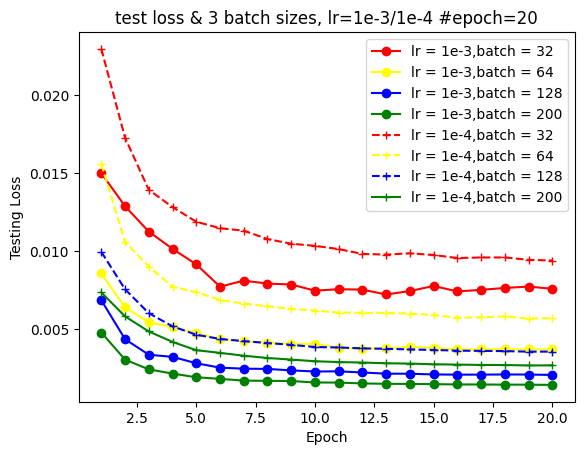

In [162]:
epochs = list(range(1, 21))
plt.plot(epochs, test_loss_4, label='lr = 1e-3,batch = 32', color='red', marker='o')
plt.plot(epochs, test_loss_5, label='lr = 1e-3,batch = 64', color='yellow', marker='o')
plt.plot(epochs, test_loss_6, label='lr = 1e-3,batch = 128', color='blue', marker='o')
plt.plot(epochs, test_loss_2, label='lr = 1e-3,batch = 200', color='green', marker='o')
plt.plot(epochs, test_loss_7, label='lr = 1e-4,batch = 32', color='red', marker='+', linestyle='--')
plt.plot(epochs, test_loss_8, label='lr = 1e-4,batch = 64', color='yellow', marker='+', linestyle='--')
plt.plot(epochs, test_loss_9, label='lr = 1e-4,batch = 128', color='blue', marker='+', linestyle='--')
plt.plot(epochs, test_loss_3, label='lr = 1e-4,batch = 200', color='green', marker='+', linestyle='-')

plt.title('test loss & 3 batch sizes, lr=1e-3/1e-4 #epoch=20')
plt.xlabel('Epoch')
plt.ylabel('Testing Loss')

# 添加图例
plt.legend()

# 显示图表
plt.savefig('results/test loss 1e-3_1e-4 bs_compare.jpg')
plt.show()

test accuracy & epoch

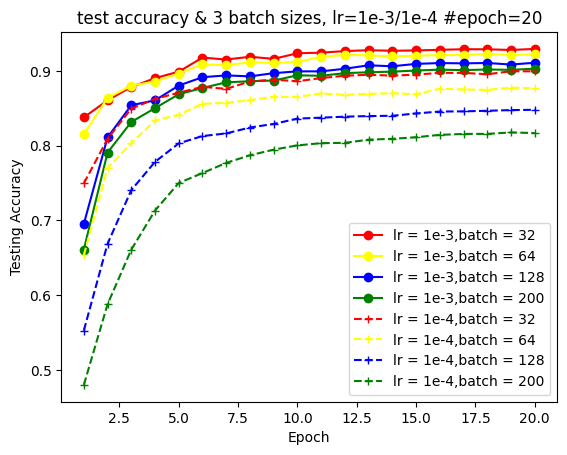

In [161]:
epochs = list(range(1, 21))
plt.plot(epochs, test_acc_4, label='lr = 1e-3,batch = 32', color='red', marker='o')
plt.plot(epochs, test_acc_5, label='lr = 1e-3,batch = 64', color='yellow', marker='o')
plt.plot(epochs, test_acc_6, label='lr = 1e-3,batch = 128', color='blue', marker='o')
plt.plot(epochs, test_acc_2, label='lr = 1e-3,batch = 200', color='green', marker='o')
plt.plot(epochs, test_acc_7, label='lr = 1e-4,batch = 32', color='red', marker='+', linestyle='--')
plt.plot(epochs, test_acc_8, label='lr = 1e-4,batch = 64', color='yellow', marker='+', linestyle='--')
plt.plot(epochs, test_acc_9, label='lr = 1e-4,batch = 128', color='blue', marker='+', linestyle='--')
plt.plot(epochs, test_acc_3, label='lr = 1e-4,batch = 200', color='green', marker='+', linestyle='--')

plt.title('test accuracy & 4 batch sizes, lr=1e-3/1e-4 #epoch=20')
plt.xlabel('Epoch')
plt.ylabel('Testing Accuracy')

# 添加图例
plt.legend()

# 显示图表
plt.savefig('results/test accuracy 1e-3_1e-4 bs_compare.jpg')
plt.show()

If learning rate is larger?

1e-1

In [177]:
test_loss_10,test_acc_10 = train_forbatchexp(optimizers[0],schedulers[0],NUM_EPOCHS,model,train_dataloader,train_set,EVAL_INTERVAL,test_dataloader,test_set,SAVE_DIR)

ValueError: loss is nan while training

1e-2

In [16]:
test_loss_11,test_acc_11 = train_forbatchexp(optimizers[1],schedulers[1],NUM_EPOCHS,model,train_dataloader,train_set,EVAL_INTERVAL,test_dataloader,test_set,SAVE_DIR)

Epoch: 1/20 Train Loss: 0.0199 Acc: 0.1007
Begin test......
Test Loss: 0.0183 Acc: 0.1000
Epoch: 2/20 Train Loss: 0.0181 Acc: 0.1001
Begin test......
Test Loss: 0.0183 Acc: 0.1000
Epoch: 3/20 Train Loss: 0.0181 Acc: 0.0978
Begin test......
Test Loss: 0.0183 Acc: 0.1000
Epoch: 4/20 Train Loss: 0.0181 Acc: 0.0982
Begin test......
Test Loss: 0.0183 Acc: 0.1000
Epoch: 5/20 Train Loss: 0.0181 Acc: 0.1023
Begin test......
Test Loss: 0.0183 Acc: 0.1000
Epoch: 6/20 Train Loss: 0.0181 Acc: 0.0981
Begin test......
Test Loss: 0.0183 Acc: 0.1000
Epoch: 7/20 Train Loss: 0.0181 Acc: 0.1014
Begin test......
Test Loss: 0.0182 Acc: 0.1000
Epoch: 8/20 Train Loss: 0.0181 Acc: 0.0992
Begin test......
Test Loss: 0.0182 Acc: 0.1000
Epoch: 9/20 Train Loss: 0.0181 Acc: 0.0991
Begin test......
Test Loss: 0.0182 Acc: 0.1000
Epoch: 10/20 Train Loss: 0.0181 Acc: 0.0989
Begin test......
Test Loss: 0.0182 Acc: 0.1000
Epoch: 11/20 Train Loss: 0.0180 Acc: 0.1004
Begin test......
Test Loss: 0.0182 Acc: 0.1000
Epoch: 1

### Task 2: Instance inference
---
The task is to visualizes an image along with model prediction and class probabilities.

**To do**: 
1. Calculate the prediction and the probabilities for each class.
         

In [14]:
inputs, classes = next(iter(test_dataloader))
input = inputs[0]
input = input.to(device)

In [15]:
##################### Write your answer here ##################
# input: image, model
# outputs: predict_label, probabilities
# predict_label is the index (or label) of the class with the highest probability from the probabilities.
###############################################################
m = nn.Softmax(dim=1)
output = model(input)
probabilities = m(output)[0]
predict_label = torch.argmax(probabilities)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


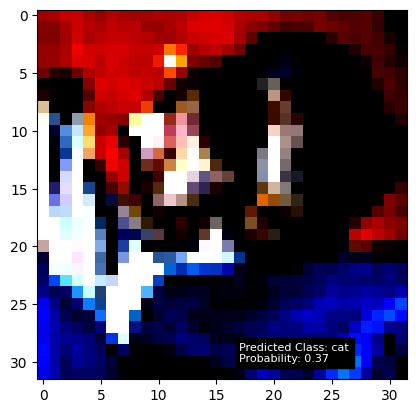

Print probabilities for each class:
airplane: 0.0249
automobile: 0.0031
bird: 0.0465
cat: 0.3710
deer: 0.0303
dog: 0.2468
frog: 0.1380
horse: 0.0427
ship: 0.0842
truck: 0.0124


In [17]:
predicted_class = class_names[predict_label.item()]
predicted_probability = probabilities[predict_label].item()
image = input.cpu().numpy().transpose((1, 2, 0))
plt.imshow(image)
plt.text(17, 30, f'Predicted Class: {predicted_class}\nProbability: {predicted_probability:.2f}', 
            color='white', backgroundcolor='black', fontsize=8)
plt.show()

# Print probabilities for each class
print('Print probabilities for each class:')
for i in range(len(class_names)):
    print(f'{class_names[i]}: {probabilities[i].item():.4f}')